# **Notebook 1: Phase 1 - Baseline & Initial Tuning**
## **Sentiment Analysis on [IMDB Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/code) using Optimized BiLSTM**

### **Overview**
This notebook initiates **Phase 1** of our research. We focus on sentiment classification of movie reviews using a **Bidirectional Long Short-Term Memory (BiLSTM)** network. To ensure the model performs at its peak, we apply five distinct metaheuristic optimization algorithms to tune the hyperparameters:
1.  **Tabu Search (TS)**
2.  **Simulated Annealing (SA)**
3. **Particle Swarm Optimization**
4.  **Whale Optimization Algorithm (WOA)**
5. **Firefly Optmization**

**Goal:** Compare the efficiency and accuracy of these algorithms in finding the optimal configuration for the BiLSTM architecture.

## **Imports and Setup**

In [1]:
!pip install torchinfo

import os, time, json, random, math, csv
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from torchinfo import summary
import seaborn as sns



2025-12-20 12:49:55.899468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766234996.092812      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766234996.148011      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766234996.615787      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766234996.615830      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766234996.615833      24 computation_placer.cc:177] computation placer alr

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE
# Fixed (NOT optimized)
FIXED_EMBED_DIM = 128
FIXED_BATCH_SIZE = 32


## **Data Loading & Preprocessing**


In [3]:
df = pd.read_csv(
    "/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv",
    sep=",",
    quotechar='"',
    quoting=csv.QUOTE_MINIMAL,
    escapechar="\\",
    engine="python"
)

df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})
print(df["label"].value_counts())


label
1    25000
0    25000
Name: count, dtype: int64


In [4]:
df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=5000, random_state=SEED))
      .reset_index(drop=True)
)

print("Final samples:", len(df))


Final samples: 10000


/tmp/ipykernel_24/3142628487.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=5000, random_state=SEED))


In [5]:
X = df["review"].values
y = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)


In [6]:
MAX_VOCAB = 30000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

def encode(texts):
    return pad_sequences(
        tokenizer.texts_to_sequences(texts),
        maxlen=MAX_LEN,
        padding="post",
        truncating="post"
    )

X_train_seq = encode(X_train)
X_val_seq   = encode(X_val)
X_test_seq  = encode(X_test)


In [7]:
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


## **Base Model Architecture: BiLSTM**
We use a **Bidirectional LSTM** because it processes sequences from both directions (past to future and future to past), allowing the model to capture better context in movie reviews.

In [8]:
class TextBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, n_layers,
            bidirectional=True, batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h = self.dropout(torch.cat((h[-2], h[-1]), dim=1))
        return self.fc(h)


In [9]:
# Model architecture visualization (example configuration)

DEMO_HIDDEN_DIM = 128
DEMO_DROPOUT = 0.5

model = TextBiLSTM(
    vocab_size=MAX_VOCAB,
    embed_dim=FIXED_EMBED_DIM,
    hidden_dim=DEMO_HIDDEN_DIM,
    output_dim=2,
    n_layers=1,
    dropout=DEMO_DROPOUT
).to(DEVICE)

dummy = torch.randint(
    0, MAX_VOCAB, (32, MAX_LEN), dtype=torch.long
).to(DEVICE)

summary(model, input_data=dummy)


Layer (type:depth-idx)                   Output Shape              Param #
TextBiLSTM                               [32, 2]                   --
├─Embedding: 1-1                         [32, 300, 128]            3,840,000
├─LSTM: 1-2                              [32, 300, 256]            264,192
├─Dropout: 1-3                           [32, 256]                 --
├─Linear: 1-4                            [32, 2]                   514
Total params: 4,104,706
Trainable params: 4,104,706
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.66
Input size (MB): 0.08
Forward/backward pass size (MB): 29.49
Params size (MB): 16.42
Estimated Total Size (MB): 45.99

In [10]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    history = {"train_loss": [], "val_accuracy": []}

    for epoch in range(epochs):
        model.train()
        loss_sum = 0

        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        history["train_loss"].append(loss_sum / len(train_loader))

        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for x, y in val_loader:
                preds.extend(model(x.to(DEVICE)).argmax(1).cpu().numpy())
                trues.extend(y.numpy())

        history["val_accuracy"].append(accuracy_score(trues, preds))

    return history


In [11]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    history = {"train_loss": [], "val_accuracy": []}

    for epoch in range(epochs):
        model.train()
        loss_sum = 0

        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        history["train_loss"].append(loss_sum / len(train_loader))

        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for x, y in val_loader:
                preds.extend(model(x.to(DEVICE)).argmax(1).cpu().numpy())
                trues.extend(y.numpy())

        history["val_accuracy"].append(accuracy_score(trues, preds))

    return history


In [12]:
def evaluate_solution(params, test=False):
    train_ds = IMDBDataset(X_train_seq, y_train)
    val_ds   = IMDBDataset(X_val_seq, y_val)
    test_ds  = IMDBDataset(X_test_seq, y_test)

    train_loader = DataLoader(
          train_ds, batch_size=FIXED_BATCH_SIZE, shuffle=True
      )
    val_loader = DataLoader(
          val_ds, batch_size=FIXED_BATCH_SIZE
      )
    test_loader = DataLoader(
          test_ds, batch_size=FIXED_BATCH_SIZE
      )


    model = TextBiLSTM(
        vocab_size=MAX_VOCAB,
        embed_dim=FIXED_EMBED_DIM,
        hidden_dim=params["hidden_dim"],
        output_dim=2,
        n_layers=1,
        dropout=params["dropout"]
    ).to(DEVICE)


    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    criterion = nn.CrossEntropyLoss()

    history = train_model(model, train_loader, val_loader, optimizer, criterion)

    val_acc = max(history["val_accuracy"])

    if not test:
        return val_acc, history

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y in test_loader:
            preds.extend(model(x.to(DEVICE)).argmax(1).cpu().numpy())
            trues.extend(y.numpy())

    return val_acc, accuracy_score(trues, preds), history


In [13]:
SUMMARY_CSV = "phase1_summary.csv"
TRACE_CSV   = "phase1_trace.csv"

def log_summary(row):
    pd.DataFrame([row]).to_csv(
        SUMMARY_CSV, mode="a", header=not os.path.exists(SUMMARY_CSV), index=False
    )

def log_trace(row):
    pd.DataFrame([row]).to_csv(
        TRACE_CSV, mode="a", header=not os.path.exists(TRACE_CSV), index=False
    )


In [14]:
SEARCH_SPACE = {
    "hidden_dim": [64, 128, 256],
    "dropout": (0.2, 0.6),
    "lr": (1e-4, 5e-3)
}

def random_solution():
    return {
        "hidden_dim": random.choice(SEARCH_SPACE["hidden_dim"]),
        "dropout": random.uniform(*SEARCH_SPACE["dropout"]),
        "lr": random.uniform(*SEARCH_SPACE["lr"])
    }

def clip_solution(sol):
    sol["hidden_dim"] = int(min(max(sol["hidden_dim"], 64), 256))
    sol["dropout"] = float(min(max(sol["dropout"], 0.2), 0.6))
    sol["lr"] = float(min(max(sol["lr"], 1e-4), 5e-3))
    return sol


## **Optimization Algorithms**

### **Tabu Search (TS)**

In [15]:
def run_tabu(iters=15, tabu_size=5):
    start = time.time()

    current = random_solution()
    best_score, best_history = evaluate_solution(current)
    best = current.copy()

    tabu_list = []

    for it in range(iters):
        neighbors = [random_solution() for _ in range(5)]
        candidates = []

        for n in neighbors:
            score, hist = evaluate_solution(n)
            candidates.append((score, n, hist))

            log_trace({
                "algorithm": "Tabu",
                "iteration": it,
                "model_params": json.dumps(n),
                "val_accuracy": score
            })

        score_n, sol_n, hist_n = max(candidates, key=lambda x: x[0])
        current = sol_n.copy()
        tabu_list.append(current)

        if score_n > best_score:
            best_score = score_n
            best = sol_n.copy()
            best_history = hist_n

    runtime = time.time() - start
    val_acc, test_acc, _ = evaluate_solution(best, test=True)

    log_summary({
        "algorithm": "Tabu",
        "algorithm_params": json.dumps({"iters": iters, "tabu_size": tabu_size}),
        "best_model_params": json.dumps(best),
        "best_val_accuracy": val_acc,
        "test_accuracy": test_acc,
        "runtime_sec": runtime,
        "seed": SEED
    })

    return best, val_acc, test_acc


### **Simulated Annealing (SA)**

In [16]:
def run_sa(iters=30, T0=1.0, alpha=0.9):
    start = time.time()

    current = random_solution()
    current_score, current_hist = evaluate_solution(current)
    best, best_score, best_history = current.copy(), current_score, current_hist
    T = T0

    for it in range(iters):
        neighbor = random_solution()
        score, hist = evaluate_solution(neighbor)

        log_trace({
            "algorithm": "SA",
            "iteration": it,
            "model_params": json.dumps(neighbor),
            "val_accuracy": score
        })

        if score > current_score or random.random() < math.exp((score - current_score) / T):
            current, current_score = neighbor.copy(), score

        if score > best_score:
            best, best_score, best_history = neighbor.copy(), score, hist

        T *= alpha

    runtime = time.time() - start
    val_acc, test_acc, _ = evaluate_solution(best, test=True)

    log_summary({
        "algorithm": "SA",
        "algorithm_params": json.dumps({"iters": iters, "T0": T0, "alpha": alpha}),
        "best_model_params": json.dumps(best),
        "best_val_accuracy": val_acc,
        "test_accuracy": test_acc,
        "runtime_sec": runtime,
        "seed": SEED
    })

    return best, val_acc, test_acc

### **Particle Swarm Optimization (PSO)**

In [17]:
def run_pso(particles=6, iters=6):
    print("Running PSO ...")
    start = time.time()

    # 1. Initialize Swarm
    # We store positions as a list of dicts, and velocities as a list of dicts
    swarm_pos = [random_solution() for _ in range(particles)]
    swarm_vel = []

    # Initialize velocities to 0
    for _ in range(particles):
        swarm_vel.append({"hidden_dim": 0, "dropout": 0.0, "lr": 0.0})

    # Track Personal Best (pbest) and Global Best (gbest)
    pbest_pos = [p.copy() for p in swarm_pos]
    pbest_score = [-1] * particles
    
    gbest_pos = None
    gbest_score = -1
    gbest_history = None

    # PSO Hyperparameters
    w = 0.5   # Inertia
    c1 = 1.5  # Cognitive (Personal)
    c2 = 1.5  # Social (Global)

    for it in range(iters):
        for i in range(particles):
            # A. Evaluate current position
            score, hist = evaluate_solution(swarm_pos[i])
            
            # Log trace
            log_trace({
                "algorithm": "PSO",
                "iteration": it,
                "model_params": json.dumps(swarm_pos[i]),
                "val_accuracy": score
            })

            #  Update Personal Best
            if score > pbest_score[i]:
                pbest_score[i] = score
                pbest_pos[i] = swarm_pos[i].copy()

            # Update Global Best
            if score > gbest_score:
                gbest_score = score
                gbest_pos = swarm_pos[i].copy()
                gbest_history = hist

        # Update Velocity and Position for NEXT iteration
        for i in range(particles):
            for param in ["hidden_dim", "dropout", "lr"]:
                r1 = random.random()
                r2 = random.random()
                
                # Standard PSO Velocity Update
                # v_new = w*v + c1*r1*(pbest - current) + c2*r2*(gbest - current)
                vel_update = (w * swarm_vel[i][param]) + \
                             (c1 * r1 * (pbest_pos[i][param] - swarm_pos[i][param])) + \
                             (c2 * r2 * (gbest_pos[param] - swarm_pos[i][param]))
                
                swarm_vel[i][param] = vel_update
                
                # Update Position
                new_val = swarm_pos[i][param] + vel_update
                swarm_pos[i][param] = new_val
            
            # Clamp/Clip logic to keep parameters valid (e.g., hidden_dim must be int)
            # Use your existing clip_solution helper, but ensure hidden_dim is int
            swarm_pos[i] = clip_solution(swarm_pos[i])
            swarm_pos[i]["hidden_dim"] = int(round(swarm_pos[i]["hidden_dim"])) # Force integer for dimension

    runtime = time.time() - start
    
    # Final Test on Best Found
    val_acc, test_acc, _ = evaluate_solution(gbest_pos, test=True)

    log_summary({
        "algorithm": "PSO",
        "algorithm_params": json.dumps({"particles": particles, "iters": iters}),
        "best_model_params": json.dumps(gbest_pos),
        "best_val_accuracy": val_acc,
        "test_accuracy": test_acc,
        "runtime_sec": runtime,
        "seed": SEED
    })

    return gbest_pos, val_acc, test_acc

### **Whale Optimization Algorithm (WOA)**

In [18]:
def run_woa(whales=6, iters=6):
    start = time.time()

    population = [random_solution() for _ in range(whales)]
    best, best_score, best_history = None, -1, None

    for it in range(iters):
        for w in population:
            score, hist = evaluate_solution(w)

            log_trace({
                "algorithm": "WOA",
                "iteration": it,
                "model_params": json.dumps(w),
                "val_accuracy": score
            })

            if score > best_score:
                best, best_score, best_history = w.copy(), score, hist

        population = [clip_solution(best.copy()) for _ in range(whales)]

    runtime = time.time() - start
    val_acc, test_acc, _ = evaluate_solution(best, test=True)

    log_summary({
        "algorithm": "WOA",
        "algorithm_params": json.dumps({"whales": whales, "iters": iters}),
        "best_model_params": json.dumps(best),
        "best_val_accuracy": val_acc,
        "test_accuracy": test_acc,
        "runtime_sec": runtime,
        "seed": SEED
    })

    return best, val_acc, test_acc


### **Firefly Optmization**

In [19]:
def run_firefly(n_fireflies=6, iters=6, beta0=1, gamma=1, alpha=0.2):
    start = time.time()

    fireflies = [random_solution() for _ in range(n_fireflies)]
    best, best_score, best_history = None, -1, None

    for it in range(iters):
        scores = []

        for f in fireflies:
            score, hist = evaluate_solution(f)
            scores.append(score)

            log_trace({
                "algorithm": "Firefly",
                "iteration": it,
                "model_params": json.dumps(f),
                "val_accuracy": score
            })

            if score > best_score:
                best, best_score, best_history = f.copy(), score, hist

        fireflies = [clip_solution(best.copy()) for _ in range(n_fireflies)]

    runtime = time.time() - start
    val_acc, test_acc, _ = evaluate_solution(best, test=True)

    log_summary({
        "algorithm": "Firefly",
        "algorithm_params": json.dumps(
            {"fireflies": n_fireflies, "iters": iters, "beta0": beta0, "gamma": gamma, "alpha": alpha}
        ),
        "best_model_params": json.dumps(best),
        "best_val_accuracy": val_acc,
        "test_accuracy": test_acc,
        "runtime_sec": runtime,
        "seed": SEED
    })

    return best, val_acc, test_acc


## **Run Algorithms**

In [20]:
run_tabu()

({'hidden_dim': 256,
  'dropout': 0.4474079009456984,
  'lr': 0.004322363811522808},
 0.79,
 0.783)

In [21]:
run_sa(iters=30)

({'hidden_dim': 256,
  'dropout': 0.4334689157164899,
  'lr': 0.0026616353061065983},
 0.755,
 0.764)

In [22]:
run_pso()

Running PSO ...


({'hidden_dim': 256,
  'dropout': 0.4494062518370756,
  'lr': 0.004633033516083438},
 0.828,
 0.802)

In [23]:
run_woa()

({'hidden_dim': 128,
  'dropout': 0.2671156573471209,
  'lr': 0.003075512720065565},
 0.791,
 0.778)

In [24]:
run_firefly()

({'hidden_dim': 128,
  'dropout': 0.35866177660665094,
  'lr': 0.003603572054742395},
 0.785,
 0.764)

## **Results**

In [25]:
# Load data
summary = pd.read_csv("phase1_summary.csv")
trace = pd.read_csv("phase1_trace.csv")

# Sort by validation accuracy to see the winner clearly
summary = summary.sort_values("best_val_accuracy", ascending=False)

display(summary[['algorithm', 'best_val_accuracy', 'test_accuracy', 'runtime_sec']])

,algorithm,best_val_accuracy,test_accuracy,runtime_sec
2,PSO,0.828,0.802,1421.462590
3,WOA,0.791,0.778,497.976130
0,Tabu,0.790,0.783,1890.230640
4,Firefly,0.785,0.764,538.745779
1,SA,0.755,0.764,546.782148


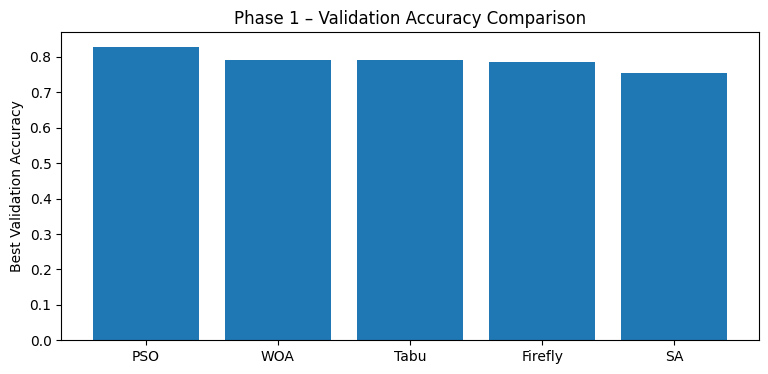

In [26]:
plt.figure(figsize=(9,4))
plt.bar(summary["algorithm"], summary["best_val_accuracy"])
plt.ylabel("Best Validation Accuracy")
plt.title("Phase 1 – Validation Accuracy Comparison")
plt.show()


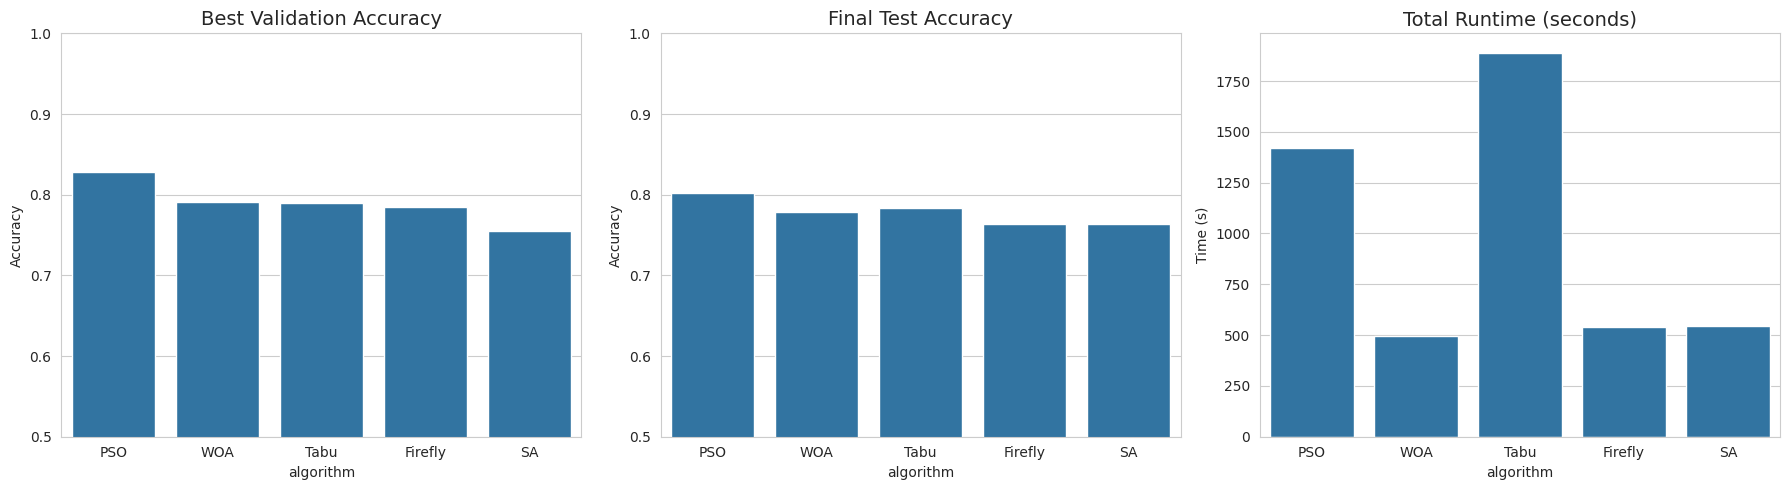

In [27]:
# --- UNIFIED BLUE PLOTS ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Validation Accuracy
sns.barplot(
    data=summary, 
    x="algorithm", 
    y="best_val_accuracy", 
    ax=axes[0], 
    color="#1f77b4"  # Unified Blue
)
axes[0].set_title("Best Validation Accuracy", fontsize=14)
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0.5, 1.0) # Adjust based on your actual range

# Plot 2: Test Accuracy
sns.barplot(
    data=summary, 
    x="algorithm", 
    y="test_accuracy", 
    ax=axes[1], 
    color="#1f77b4"
)
axes[1].set_title("Final Test Accuracy", fontsize=14)
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0.5, 1.0)

# Plot 3: Runtime
sns.barplot(
    data=summary, 
    x="algorithm", 
    y="runtime_sec", 
    ax=axes[2], 
    color="#1f77b4"
)
axes[2].set_title("Total Runtime (seconds)", fontsize=14)
axes[2].set_ylabel("Time (s)")

plt.tight_layout()
plt.show()

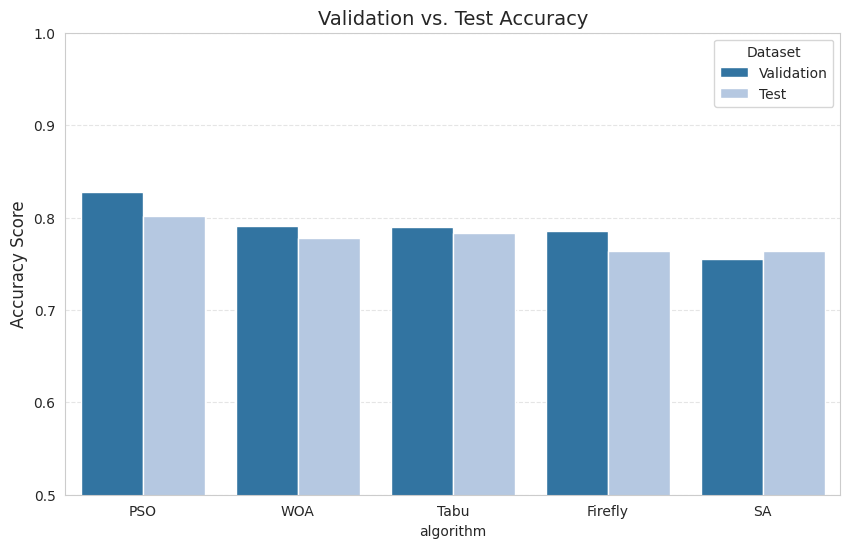

In [28]:
summary_melt = summary.melt(
    id_vars=["algorithm"], 
    value_vars=["best_val_accuracy", "test_accuracy"],
    var_name="Metric", 
    value_name="Accuracy"
)

# Rename for cleaner legend
summary_melt["Metric"] = summary_melt["Metric"].replace({
    "best_val_accuracy": "Validation",
    "test_accuracy": "Test"
})

plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_melt, 
    x="algorithm", 
    y="Accuracy", 
    hue="Metric", 
    palette=["#1f77b4", "#aec7e8"] # Dark Blue vs Light Blue
)

plt.title("Validation vs. Test Accuracy", fontsize=14)
plt.ylabel("Accuracy Score", fontsize=12)
plt.ylim(0.5, 1.0) # Adjust scale to see differences clearly
plt.legend(title="Dataset")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

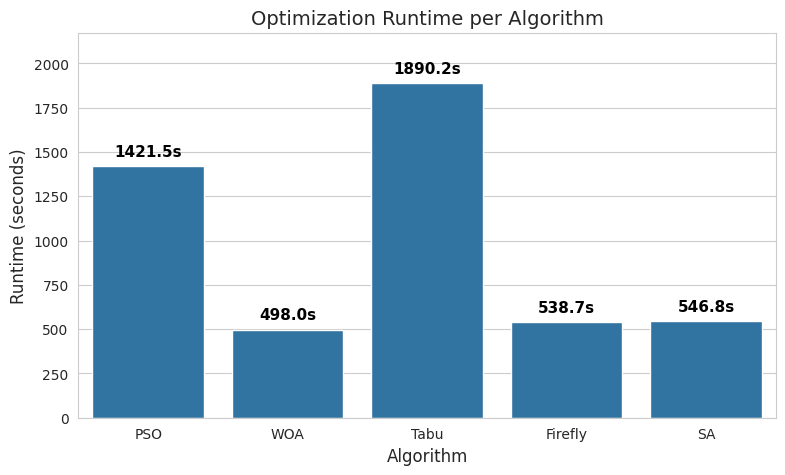

In [29]:
plt.figure(figsize=(9, 5))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=summary,
    x="algorithm",
    y="runtime_sec",
    color="#1f77b4"  
)

# Add exact numbers on top of each bar
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.1f}s',  # Format as 1 decimal place (e.g., 45.2s)
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom', 
        fontsize=11, color='black', fontweight='bold',
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.ylabel("Runtime (seconds)", fontsize=12)
plt.xlabel("Algorithm", fontsize=12)
plt.title("Optimization Runtime per Algorithm", fontsize=14)
plt.ylim(0, summary["runtime_sec"].max() * 1.15) # Add 15% headroom for labels
plt.show()

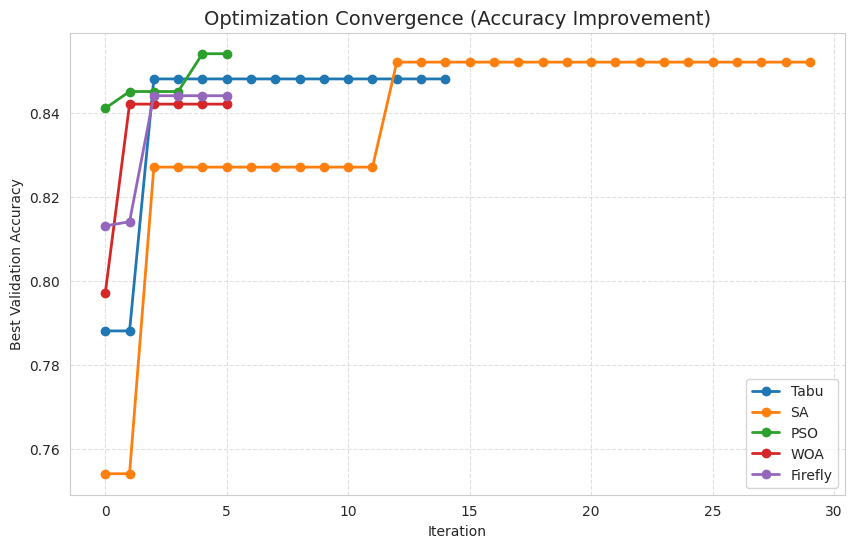

In [30]:
plt.figure(figsize=(10, 6))

# Plot the max accuracy found per iteration for each algorithm
for alg in trace["algorithm"].unique():
    sub = trace[trace["algorithm"] == alg]
    # Get the best score up to that iteration
    best_per_iter = sub.groupby("iteration")["val_accuracy"].max().cummax()
    
    plt.plot(
        best_per_iter.index, 
        best_per_iter.values, 
        marker='o', 
        linewidth=2, 
        label=alg
    )

plt.title("Optimization Convergence (Accuracy Improvement)", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("Best Validation Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()